In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import pathlib
import numpy as np
import pandas as pd

dim = 16
directory = pathlib.Path("../events/MG3")

df_3b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbj.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbb_large.h5")
df_hh4b = pd.read_hdf(directory / "dataframes" / "symmetrized_HH4b.h5")

df_3b["signal"] = 0
df_bg4b["signal"] = 0
df_hh4b["signal"] = 1

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_hh4b))

display(df_3b["weight"].describe())
display(df_bg4b["weight"].describe())
display(df_hh4b["weight"].describe())

# normalize weights?
df_hh4b["weight"] /= df_hh4b["weight"].mean()

3b-jet events:  275508
4b-jet events:  382108
HH4b-jet events:  28656


count    275508.000000
mean          1.013414
std           0.108394
min           0.763009
25%           0.950273
50%           0.994248
75%           1.044556
max           3.796323
Name: weight, dtype: float64

count    382108.000000
mean          1.009346
std           0.047811
min           0.764206
25%           0.978478
50%           1.004778
75%           1.033707
max           2.404915
Name: weight, dtype: float64

count    28656.000000
mean         0.000542
std          0.000269
min          0.000317
25%          0.000436
50%          0.000452
75%          0.000469
max          0.001455
Name: weight, dtype: float64

In [3]:
n_3b = 250000
n_all4b = 250000
signal_ratio = 0.05

In [4]:
import pytorch_lightning as pl
from torch.utils.data import TensorDataset

np.random.seed(42)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

# features = ["canJet0_pt", "canJet1_pt", "canJet2_pt", "canJet3_pt",
#             "canJet0_eta", "canJet1_eta", "canJet2_eta", "canJet3_eta",
#             "canJet0_phi", "canJet1_phi", "canJet2_phi", "canJet3_phi",
#             "canJet0_m", "canJet1_m", "canJet2_m", "canJet3_m"]

pl.seed_everything(42)
np.random.seed(42)

test_ratio = 0.2

n_3b_clf = int(n_3b * (1 - test_ratio))
n_all4b_clf = int(n_all4b * (1 - test_ratio))
n_bg4b_clf = n_all4b_clf - int(n_all4b_clf * signal_ratio)
n_hh4b_clf = int(n_all4b_clf * signal_ratio)

n_3b_test = n_3b - n_3b_clf
n_all4b_test = n_all4b - n_all4b_clf
n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
n_hh4b_test = int(n_all4b_test * signal_ratio)

df_clf = pd.concat([df_3b.iloc[:n_3b_clf], df_bg4b.iloc[:n_bg4b_clf], df_hh4b.iloc[:n_hh4b_clf]])
df_test = pd.concat([df_3b.iloc[n_3b_clf:n_3b_clf+n_3b_test], 
                     df_bg4b.iloc[n_bg4b_clf:n_bg4b_clf+n_bg4b_test], 
                     df_hh4b.iloc[n_hh4b_clf:n_hh4b_clf+n_hh4b_test]])
# reduce number of 4b samples to 1/8
# df_clf = pd.concat([df_3b.iloc[df3b_index], df_bg4b.iloc[df4b_index[::8]]])
print("4b ratio: ", df_clf["fourTag"].sum() / df_clf["fourTag"].size)
print("Signal ratio: ", df_clf["signal"].sum() / np.sum(df_clf["fourTag"]))

# for i in range(4):
#     df_clf[f"sym_canJet{i}_phi"] = np.pi * (i / 3) - np.pi
#     # uniform from [-0.5, 0.5]
#     df_clf[f"sym_canJet{i}_m"] = 0

# shuffle the data
df_clf = df_clf.sample(frac=1, random_state=42).reset_index(drop=True)
# For ghostbatch, let len(train_indices) be a multiple of 32
split_at = 1024 * (int((2/3) * df_clf.index.size) // 1024)
end_at = 1024 * (df_clf.index.size // 1024)

X_train = torch.tensor(df_clf[features].values, dtype=torch.float32)[:split_at]
w_train = torch.tensor(df_clf["weight"].values, dtype=torch.float32)[:split_at]
y_train = torch.tensor(df_clf["fourTag"].values, dtype=torch.long)[:split_at]
is_signal = torch.tensor(df_clf["signal"].values, dtype=torch.long)[:split_at]

X_val = torch.tensor(df_clf[features].values, dtype=torch.float32)[split_at:end_at]
w_val = torch.tensor(df_clf["weight"].values, dtype=torch.float32)[split_at:end_at]
y_val = torch.tensor(df_clf["fourTag"].values, dtype=torch.long)[split_at:end_at]
is_signal_val = torch.tensor(df_clf["signal"].values, dtype=torch.long)[split_at:end_at]

train_dataset = TensorDataset(X_train, y_train, w_train)
val_dataset = TensorDataset(X_val, y_val, w_val)

Seed set to 42


4b ratio:  0.5
Signal ratio:  0.05


In [5]:
from ancillary_features import PtEtaPhi_to_PxPyPz

# add Px, Py, Pz
for i in range(4):
    for prefix in ["sym_", ""]:
        phi = torch.tensor(df_clf[f"{prefix}canJet{i}_phi"].values)
        eta = torch.tensor(df_clf[f"{prefix}canJet{i}_eta"].values)
        pt = torch.tensor(df_clf[f"{prefix}canJet{i}_pt"].values)
        px, py, pz = PtEtaPhi_to_PxPyPz(pt, eta, phi)
        df_clf[f"{prefix}canJet{i}_px"] = px.numpy()
        df_clf[f"{prefix}canJet{i}_py"] = py.numpy()
        df_clf[f"{prefix}canJet{i}_pz"] = pz.numpy()

Before Considering Symmetry


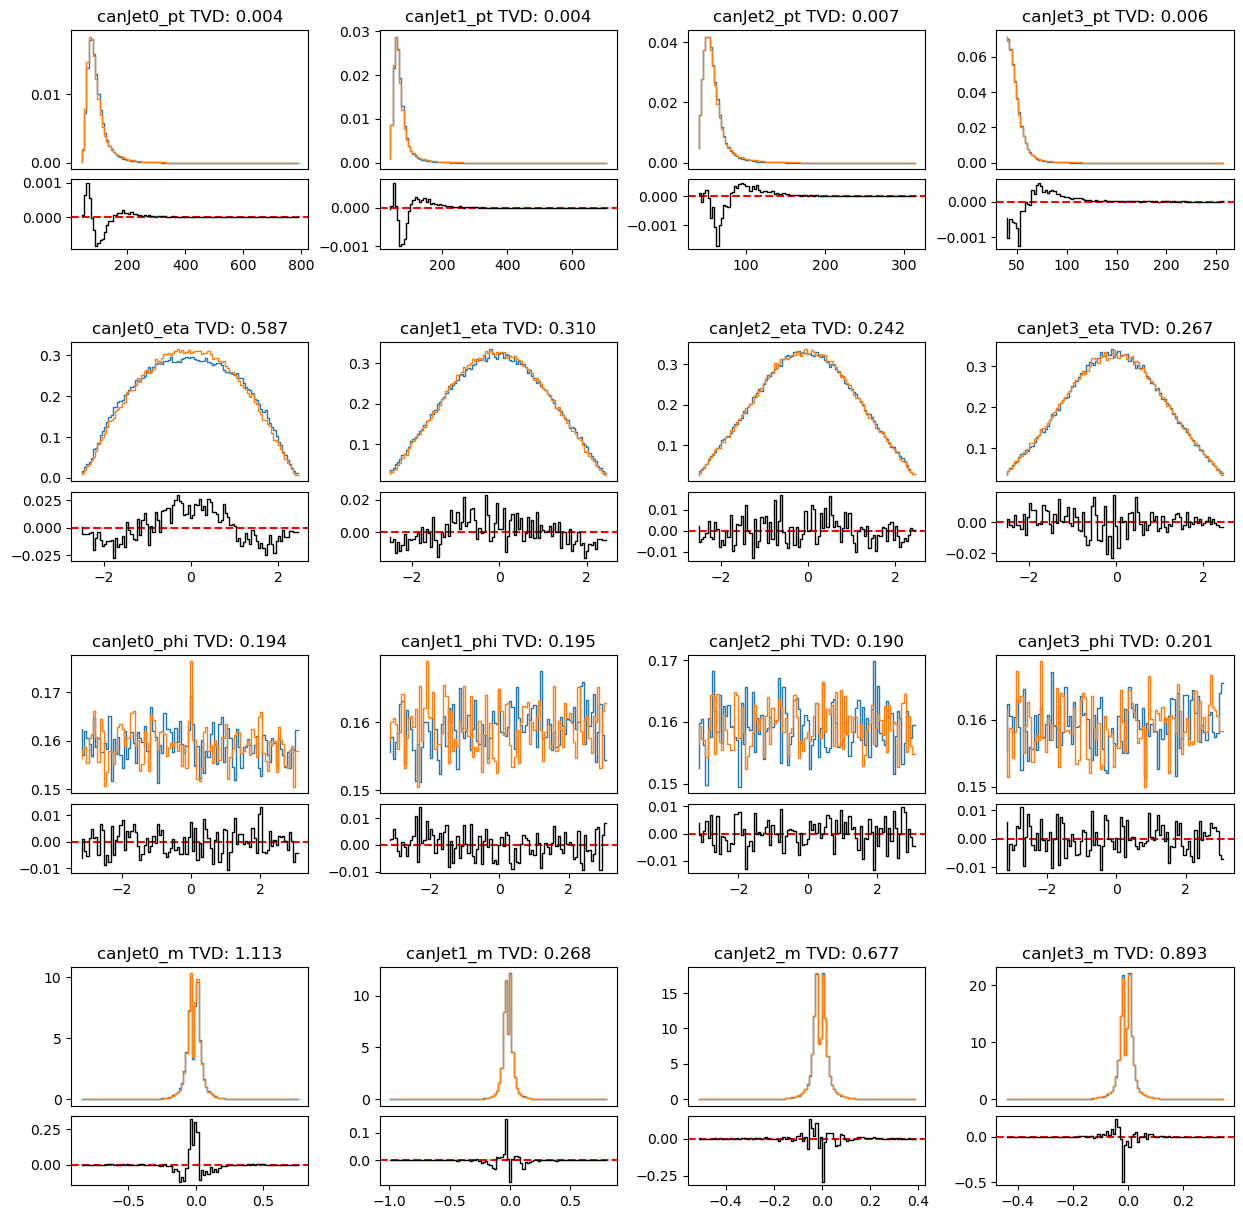

After Considering Symmetry


/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_305606/2361873862.py:67: RuntimeWarning: invalid value encountered in subtract
  tvd = 0.5 * np.sum(np.abs(feat_hist_3b - feat_hist_4b))
/tmp/ipykernel_305606/2361873862.py:74: RuntimeWarning: invalid value encountered in subtract
  ratio = feat_hist_4b - feat_hist_3b


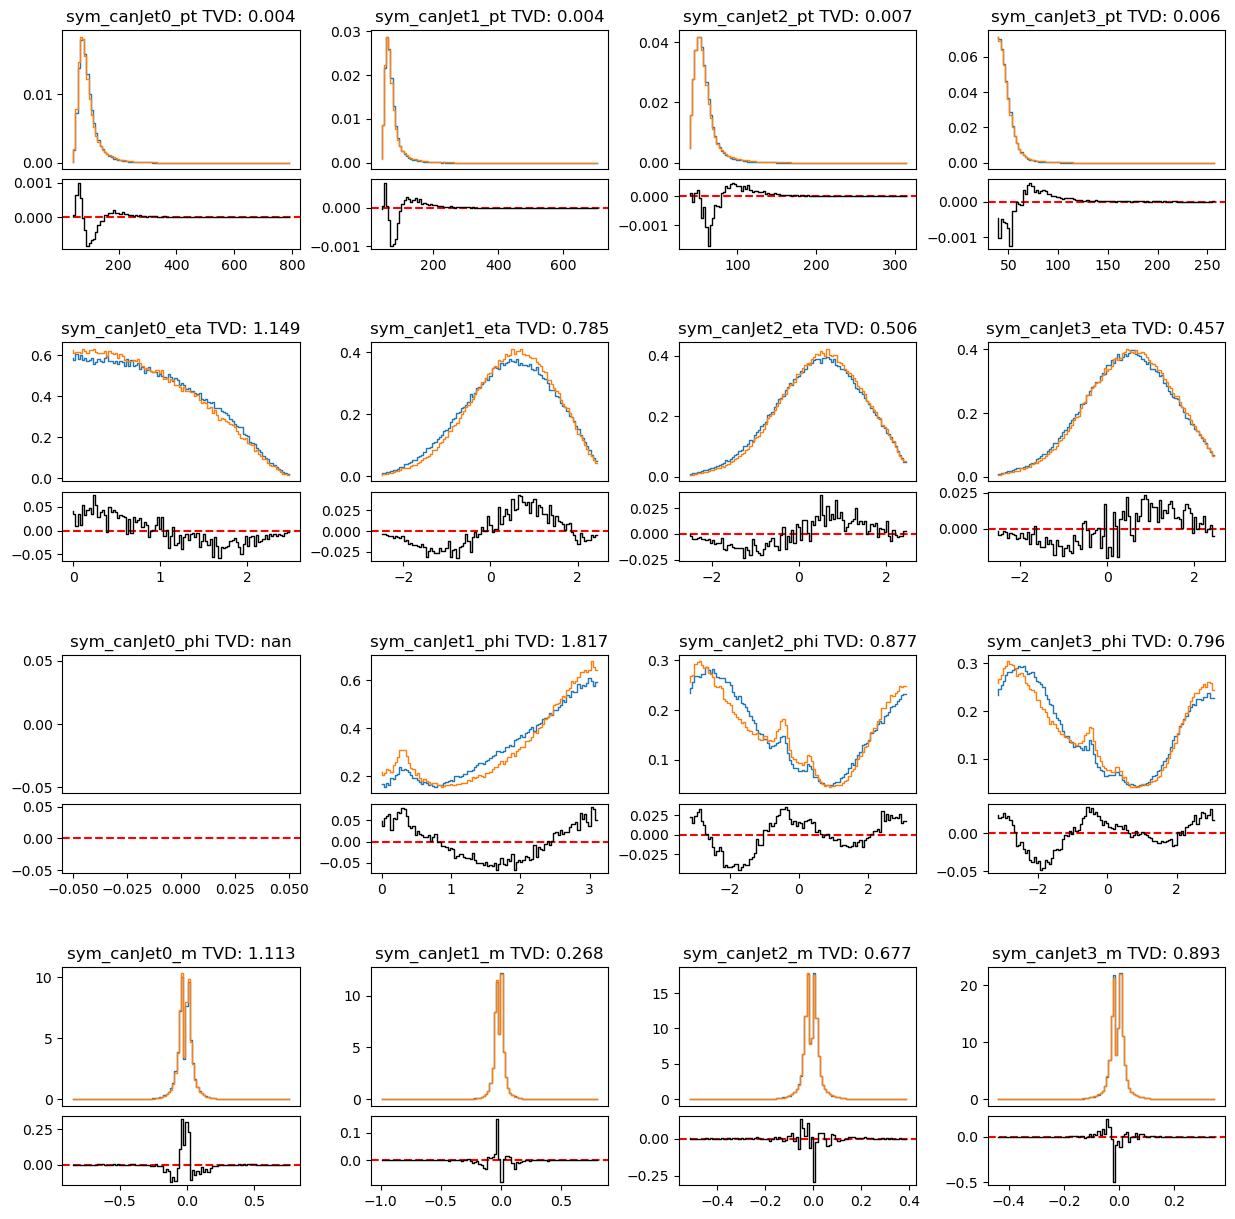

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 15))
outer = gridspec.GridSpec(8, 4, hspace=1.5, wspace=0.3)
is_4b = df_clf["fourTag"] == 1

                        

print("Before Considering Symmetry")
features_ptetaphi = ["canJet0_pt", "canJet1_pt", "canJet2_pt", "canJet3_pt",
                        "canJet0_eta", "canJet1_eta", "canJet2_eta", "canJet3_eta",
                        "canJet0_phi", "canJet1_phi", "canJet2_phi", "canJet3_phi",
                        "canJet0_m", "canJet1_m", "canJet2_m", "canJet3_m"]

for i in range(4):
    for j in range(4):
        feature = features_ptetaphi[i*4 + j]
        bins_range = np.linspace(df_clf[feature].min(), df_clf[feature].max(), 100)
        feat_hist_3b, _ = np.histogram(df_clf.loc[~is_4b, feature].values, bins=bins_range, density=True)
        feat_hist_4b, _ = np.histogram(df_clf.loc[is_4b, feature].values, bins=bins_range, density=True)

        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.1, height_ratios=[2, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.step(bins_range[:-1], feat_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], feat_hist_4b, label="4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(feat_hist_3b - feat_hist_4b))
        current_ax.set_title(f"{feature} TVD: {tvd:.3f}")
        # remove x labels
        current_ax.set_xticks([])
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])
        ratio = feat_hist_4b - feat_hist_3b
        current_ax.axhline(0, color="red", linestyle="--")
        current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        fig.add_subplot(current_ax)


plt.show()
plt.close()

fig = plt.figure(figsize=(15, 15))
outer = gridspec.GridSpec(8, 4, hspace=1.5, wspace=0.3)


features_ptetaphi = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
                        "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
                        "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
                        "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

print("After Considering Symmetry")

for i in range(4):
    for j in range(4):
        feature = features_ptetaphi[i*4 + j]
        bins_range = np.linspace(df_clf[feature].min(), df_clf[feature].max(), 100)
        feat_hist_3b, _ = np.histogram(df_clf.loc[~is_4b, feature].values, bins=bins_range, density=True)
        feat_hist_4b, _ = np.histogram(df_clf.loc[is_4b, feature].values, bins=bins_range, density=True)

        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.1, height_ratios=[2, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.step(bins_range[:-1], feat_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], feat_hist_4b, label="4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(feat_hist_3b - feat_hist_4b))
        current_ax.set_title(f"{feature} TVD: {tvd:.3f}")
        # remove x labels
        current_ax.set_xticks([])
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])
        ratio = feat_hist_4b - feat_hist_3b
        current_ax.axhline(0, color="red", linestyle="--")
        current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        fig.add_subplot(current_ax)

plt.show()
plt.close()

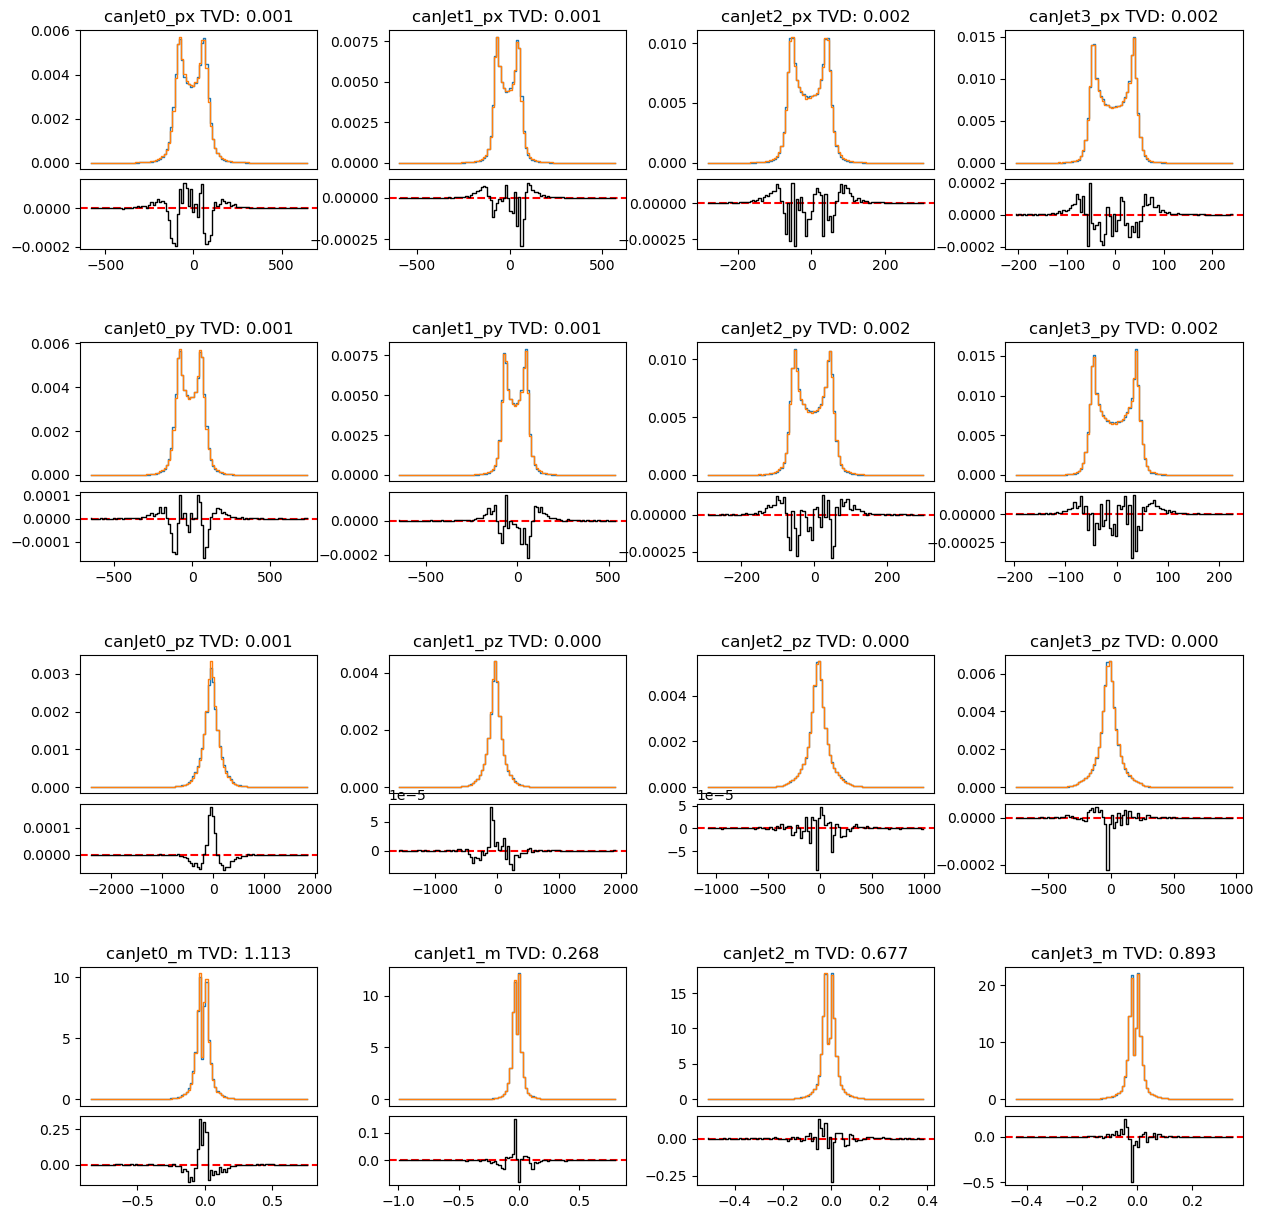

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 15))
outer = gridspec.GridSpec(8, 4, hspace=1.5, wspace=0.3)
is_4b = df_clf["fourTag"] == 1

features_pxpypz = ["canJet0_px", "canJet1_px", "canJet2_px", "canJet3_px",
                   "canJet0_py", "canJet1_py", "canJet2_py", "canJet3_py",
                   "canJet0_pz", "canJet1_pz", "canJet2_pz", "canJet3_pz",
                     "canJet0_m", "canJet1_m", "canJet2_m", "canJet3_m"]
                   
for i in range(4):
    for j in range(4):
        feature = features_pxpypz[i*4 + j]
        bins_range = np.linspace(df_clf[feature].min(), df_clf[feature].max(), 100)
        feat_hist_3b, _ = np.histogram(df_clf.loc[~is_4b, feature].values, bins=bins_range, density=True)
        feat_hist_4b, _ = np.histogram(df_clf.loc[is_4b, feature].values, bins=bins_range, density=True)

        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.1, height_ratios=[2, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.step(bins_range[:-1], feat_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], feat_hist_4b, label="4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(feat_hist_3b - feat_hist_4b))
        current_ax.set_title(f"{feature} TVD: {tvd:.3f}")
        # remove x labels
        current_ax.set_xticks([])
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])
        ratio = feat_hist_4b - feat_hist_3b
        current_ax.axhline(0, color="red", linestyle="--")
        current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        fig.add_subplot(current_ax)


plt.show()
plt.close()

In [8]:
from fvt_classifier import FvTClassifier

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 30
run_name = "_".join(["fvt_classifier_toy_signal_ratio", 
                    f"signal_ratio={signal_ratio}", 
                    f"dijet={dim_dijet_features}", 
                    f"quadjet={dim_quadjet_features}"])
lr = 1e-3

pl.seed_everything(42)

model = FvTClassifier(num_classes, 
                       dim_input_jet_features, 
                       dim_dijet_features, 
                       dim_quadjet_features, 
                       run_name=run_name,
                       device=torch.device("cuda:0"),
                       lr=lr)

model.fit(train_dataset, val_dataset, batch_size=1024, max_epochs=max_epochs)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 260/260 [00:03<00:00, 69.08it/s, v_num=0, val_loss=0.684, train_loss=0.684]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 260/260 [00:03<00:00, 68.97it/s, v_num=0, val_loss=0.684, train_loss=0.684]


In [9]:
from torch.utils.data import DataLoader


model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
device = torch.device("cuda:0")
model = model.to(device)

q_repr = []

for batch in val_loader:
    x, y, w = batch
    x = x.to(device)
    q = model.encoder(x)
    q_repr.append(q.detach().cpu().numpy())

q_repr = np.concatenate(q_repr, axis=0)
labels_4b = y_val.cpu().numpy()
probs_4b = model.predict(X_val)[:, 1].cpu().numpy()
weights_4b = w_val.cpu().numpy()
is_signal = is_signal_val.cpu().numpy()

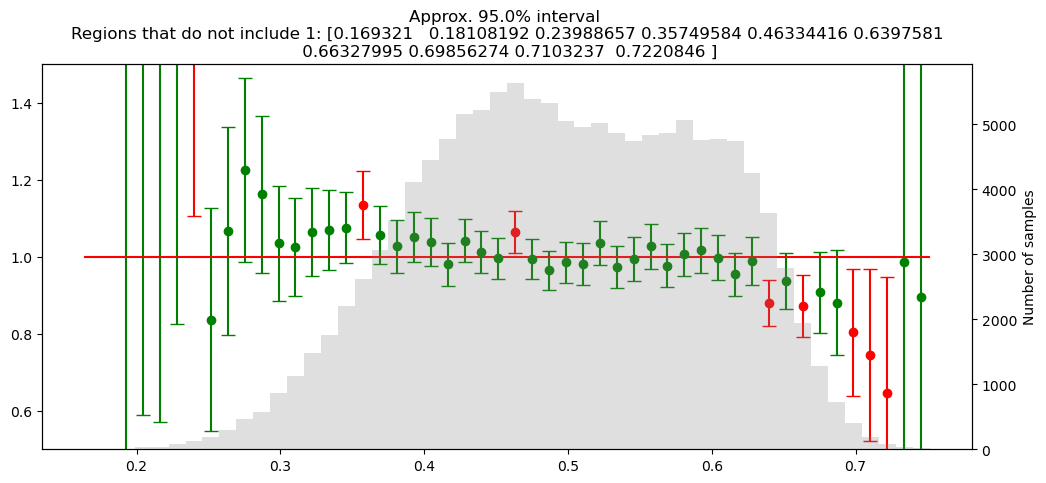

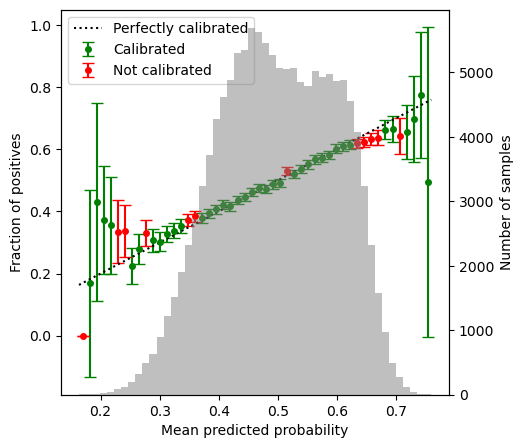

In [10]:
from plots import plot_prob_weighted_histogram1d, calibration_plot
%matplotlib inline
plot_feature_arr = probs_4b
plot_prob_weighted_histogram1d(probs_4b, plot_feature_arr, labels_4b,
                               n_bins=50, 
                               sample_weights=weights_4b,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b, labels_4b,
                 bins=50,
                 sample_weights=weights_4b)

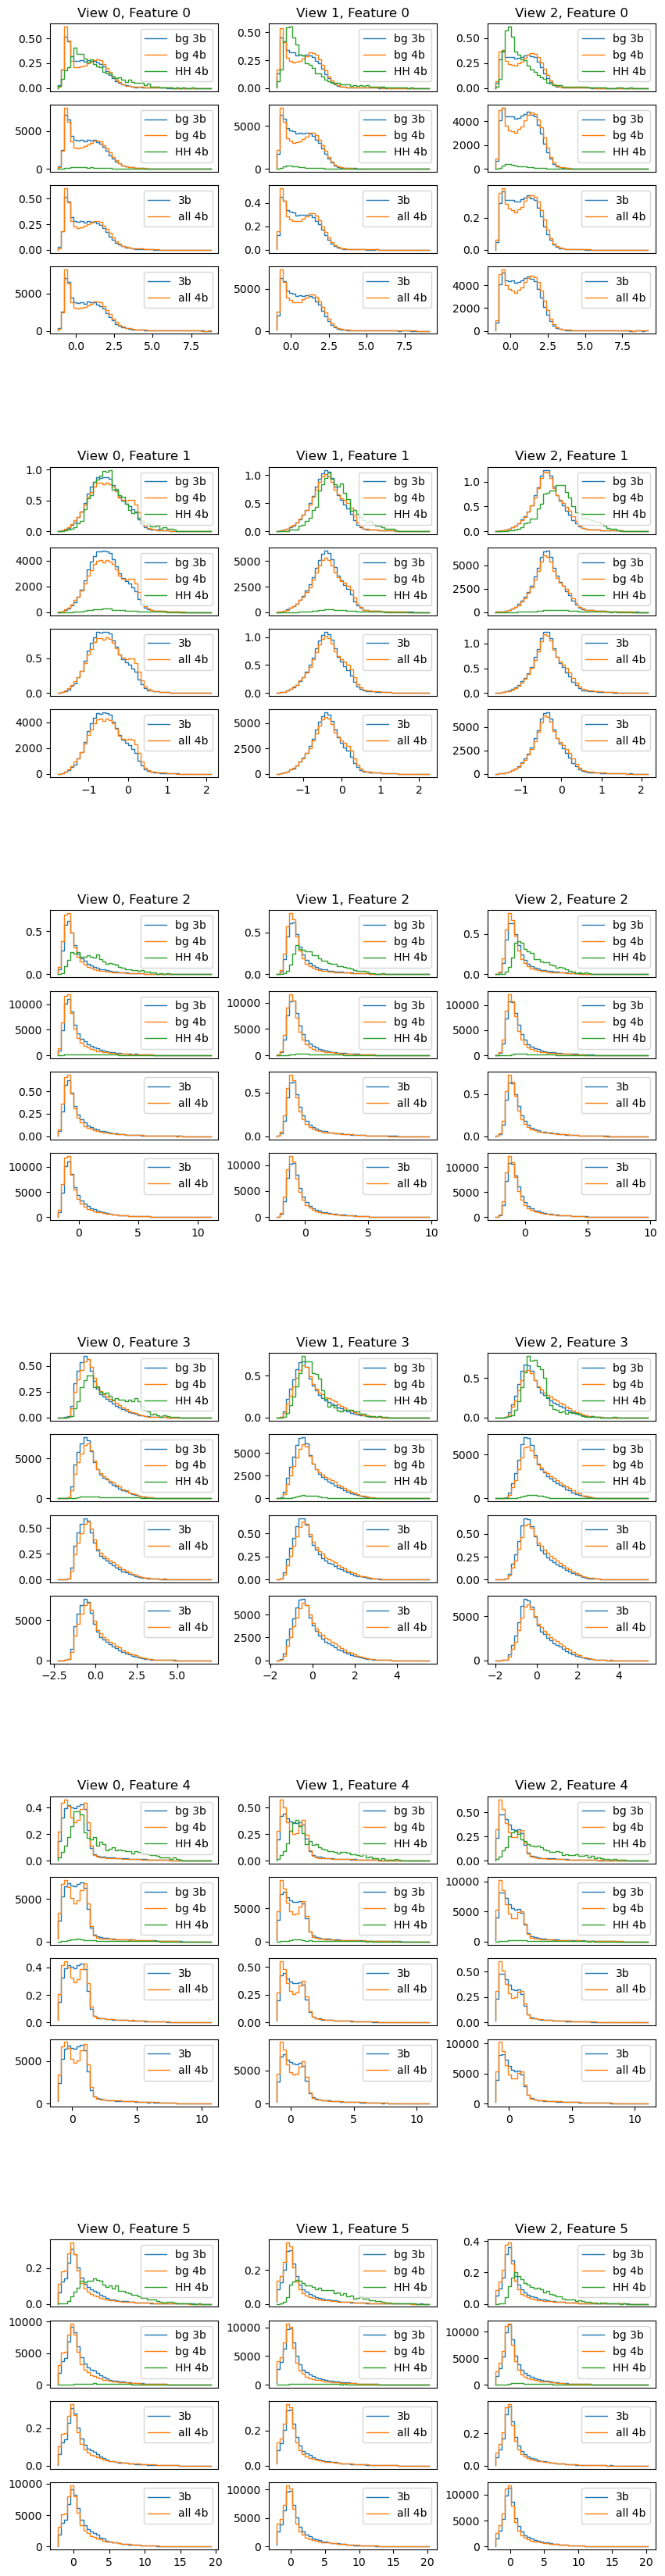

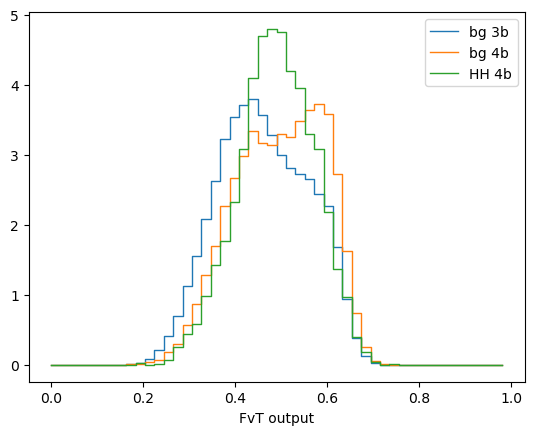

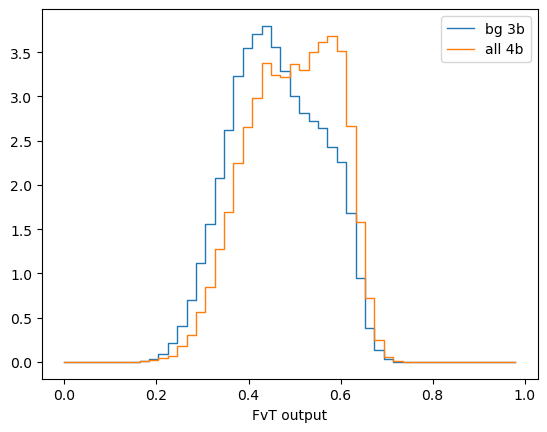

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 3.5 * 2 * dim_quadjet_features))
outer = gridspec.GridSpec(2*dim_quadjet_features, 3, hspace=1.5, wspace=0.3)

is_3b = labels_4b == 0
is_bg4b = (labels_4b == 1) & (is_signal == 0)
is_hh4b = (labels_4b == 1) & (is_signal == 1)
plot_density = True

for i in range(dim_quadjet_features):
    for j in range(3):
        
        repr_min, repr_max = np.min(q_repr[:, i, j]), np.max(q_repr[:, i, j])
        bins_range = np.linspace(repr_min, repr_max, 50)
        repr_hist_3b, _ = np.histogram(q_repr[is_3b, i, j], bins=bins_range, density=True)
        repr_hist_4b, _ = np.histogram(q_repr[is_bg4b, i, j], bins=bins_range, density=True)
        repr_hist_hh4b, _ = np.histogram(q_repr[is_hh4b, i, j], bins=bins_range, density=True)

        inner = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.2, height_ratios=[1, 1, 1, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.step(bins_range[:-1], repr_hist_3b, label="bg 3b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_4b, label="bg 4b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_hh4b, label="HH 4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
        current_ax.set_title(f"View {j}, Feature {i}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])

        repr_hist_3b, _ = np.histogram(q_repr[is_3b, i, j], bins=bins_range, density=False)
        repr_hist_4b, _ = np.histogram(q_repr[is_bg4b, i, j], bins=bins_range, density=False)
        repr_hist_hh4b, _ = np.histogram(q_repr[is_hh4b, i, j], bins=bins_range, density=False)

        current_ax.step(bins_range[:-1], repr_hist_3b, label="bg 3b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_4b, label="bg 4b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_hh4b, label="HH 4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
        # current_ax.set_title(f"View {j}, Feature {i}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[2])
        # ratio = repr_hist_4b - repr_hist_3b
        # current_ax.axhline(0, color="red", linestyle="--")
        # current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        # fig.add_subplot(current_ax)
        repr_hist_3b, _ = np.histogram(q_repr[is_3b, i, j], bins=bins_range, density=True)
        repr_hist_4b_all, _ = np.histogram(q_repr[labels_4b == 1, i, j], bins=bins_range, density=True)
        current_ax.step(bins_range[:-1], repr_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_4b_all, label="all 4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b_all))
        # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()

        fig.add_subplot(current_ax)
        current_ax = plt.Subplot(fig, inner[3])
        # ratio = repr_hist_4b - repr_hist_3b
        # current_ax.axhline(0, color="red", linestyle="--")
        # current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        # fig.add_subplot(current_ax)
        repr_hist_3b, _ = np.histogram(q_repr[is_3b, i, j], bins=bins_range, density=False)
        repr_hist_4b_all, _ = np.histogram(q_repr[labels_4b == 1, i, j], bins=bins_range, density=False)
        current_ax.step(bins_range[:-1], repr_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_4b_all, label="all 4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b_all))
        # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
        # remove x labels
        current_ax.legend()
        fig.add_subplot(current_ax)


plt.show()
plt.close()

bins_range = np.linspace(0, 1, 50)
repr_hist_3b, _ = np.histogram(probs_4b[is_3b], bins=bins_range, density=True)
repr_hist_4b, _ = np.histogram(probs_4b[is_bg4b], bins=bins_range, density=True)
repr_hist_hh4b, _ = np.histogram(probs_4b[is_hh4b], bins=bins_range, density=True)
repr_hist_4b_all, _ = np.histogram(probs_4b[labels_4b == 1], bins=bins_range, density=True)

fig, ax = plt.subplots()
ax.step(bins_range[:-1], repr_hist_3b, label="bg 3b", linewidth=1)
ax.step(bins_range[:-1], repr_hist_4b, label="bg 4b", linewidth=1)
ax.step(bins_range[:-1], repr_hist_hh4b, label="HH 4b", linewidth=1)
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

fig, ax = plt.subplots()
ax.step(bins_range[:-1], repr_hist_3b, label="bg 3b", linewidth=1)
ax.step(bins_range[:-1], repr_hist_4b_all, label="all 4b", linewidth=1)
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SvBSimple(nn.Module):
    def __init__(self, dim_quadjet_features):
        super(SvBSimple, self).__init__()
        
        self.att_net = nn.Sequential(
            nn.Linear(dim_quadjet_features, 16),
            nn.BatchNorm1d(16),
            nn.SiLU(),
            nn.Linear(16, 16),
            nn.BatchNorm1d(16),
            nn.SiLU(),
            nn.Linear(16, 1)
        )

        self.score_net = nn.Sequential(
            nn.Linear(dim_quadjet_features, 16),
            nn.BatchNorm1d(16),
            nn.SiLU(),
            nn.Linear(16, 16),
            nn.BatchNorm1d(16),
            nn.SiLU(),
            nn.Linear(16, 2), 
        )

    def forward(self, x):
        # x: (batch_size, dim_quadjet_features, 3)
        att = [self.att_net(x[..., i]) for i in range(x.size(2))]
        att = torch.cat(att, dim=-1)
        att = F.softmax(att, dim=-1)
        # att: (batch_size, 3)
        x = torch.sum(att.unsqueeze(1) * x, dim=-1)
        score = self.score_net(x)
        return score
    
    def loss(self, x, y):
        return F.cross_entropy(self.forward(x), y, reduction="none", weight=torch.tensor([1, 10], dtype=torch.float32).to(x.device))
    
    def predict(self, x):
        return torch.argmax(self.forward(x), dim=-1)
    
    def logit(self, x):
        fwd = self.forward(x)
        return fwd[..., 1] - fwd[..., 0]
    
    def fit(self, train_dataloader, val_dataloader, optimizer, n_epochs):
        for epoch in range(n_epochs):
            self.train()
            for x, y, w in train_dataloader:
                optimizer.zero_grad()
                x = x.to(device)
                y = y.to(device)
                w = w.to(device)
                loss = self.loss(x, y)
                loss = (loss * w).mean()
                loss.backward()
                optimizer.step()
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for x, y, w in val_dataloader:
                    x = x.to(device)
                    y = y.to(device)
                    w = w.to(device)
                    val_loss += (w * self.loss(x, y)).sum()
                    val_loss /= len(val_dataloader)
                if epoch % 5 == 0: print(f"Epoch {epoch} Val Loss: {val_loss}")

# Test dataset (Not validation dataset)

In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_test = torch.tensor(df_test[features].values, dtype=torch.float32)
is_4b_test = torch.tensor(df_test["fourTag"].values, dtype=torch.long)
w_test = torch.tensor(df_test["weight"].values, dtype=torch.float32)
is_signal_test = torch.tensor(df_test["signal"].values, dtype=torch.long)
svb_test_dataset = TensorDataset(X_test, is_4b_test, w_test)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
test_loader = DataLoader(svb_test_dataset, batch_size=1024, shuffle=False)
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

q_repr_test = []

for batch in test_loader:
    x, y, w = batch
    x = x.to(device)
    q = fvt_model.encoder(x)
    q_repr_test.append(q.detach().cpu().numpy())

q_repr_test = np.concatenate(q_repr_test, axis=0)
labels_4b_test = is_4b_test.cpu().numpy()
probs_4b_test = fvt_model.predict(X_test)[:, 1].cpu().numpy()
weights_4b_test = w_test.cpu().numpy()
is_signal_test = is_signal_test.cpu().numpy()

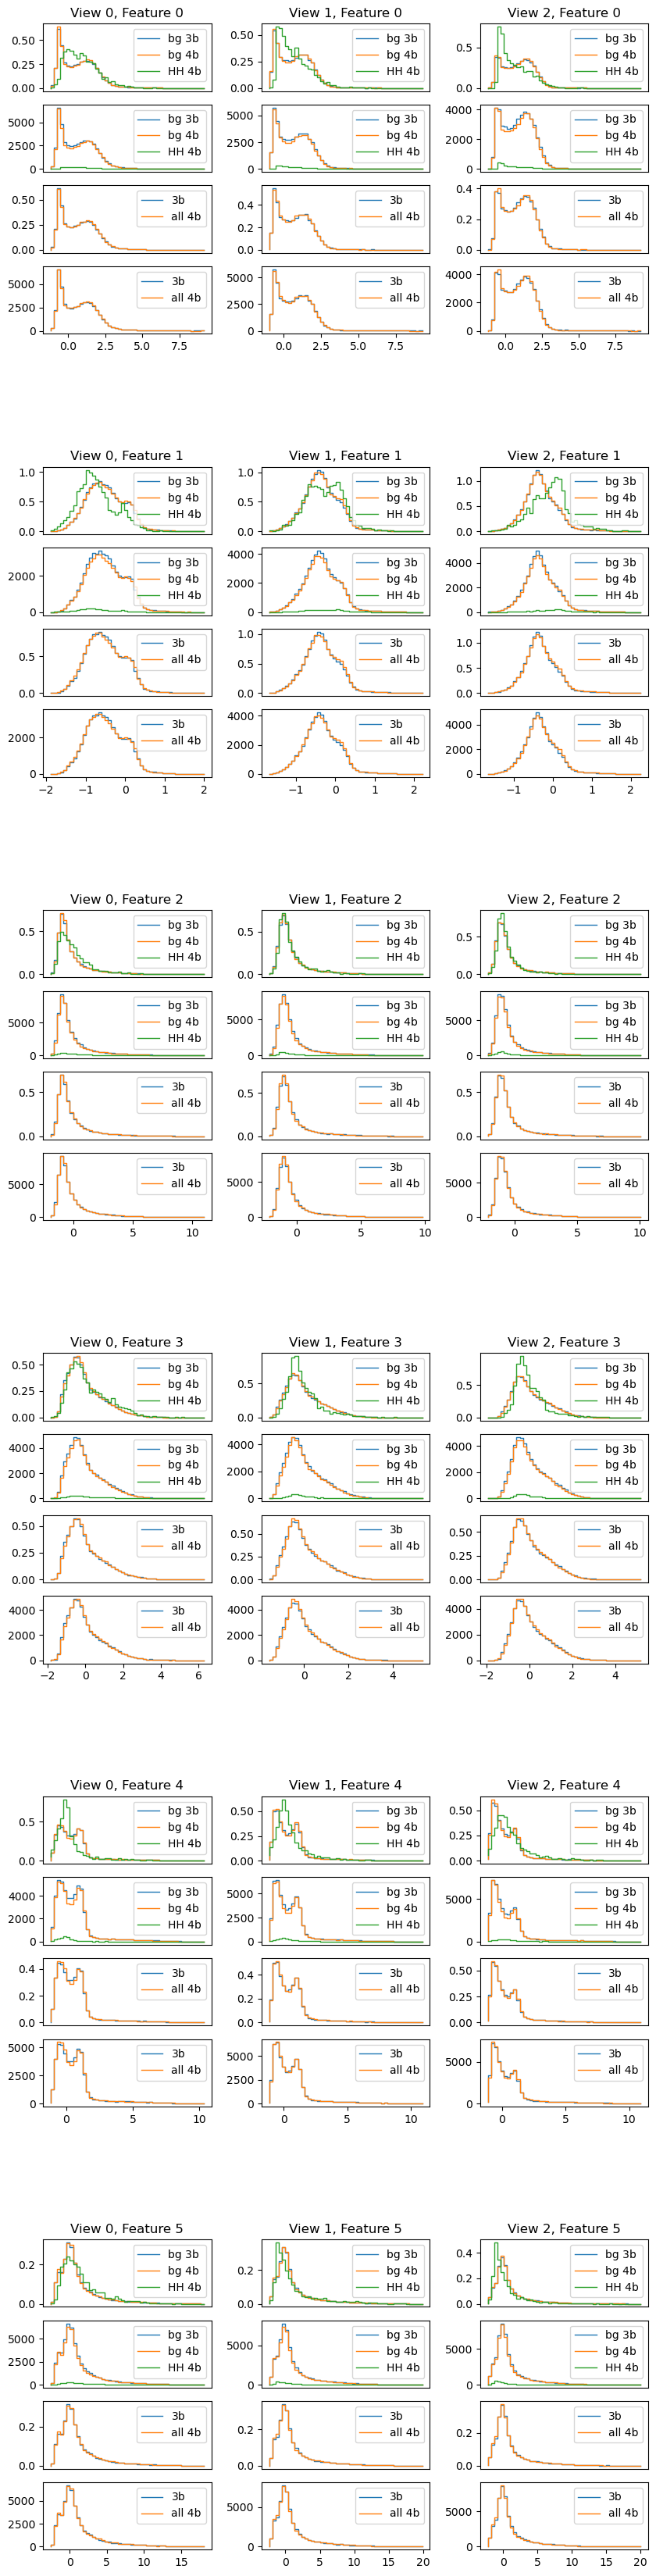

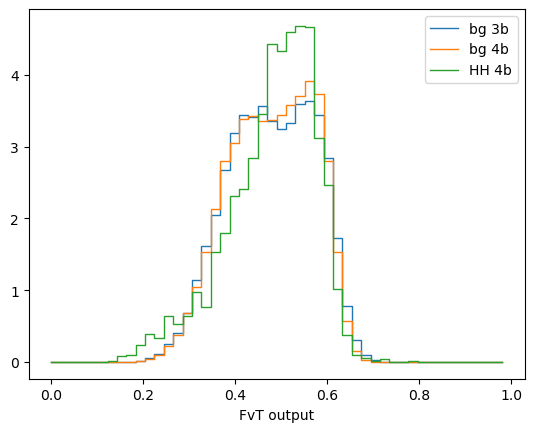

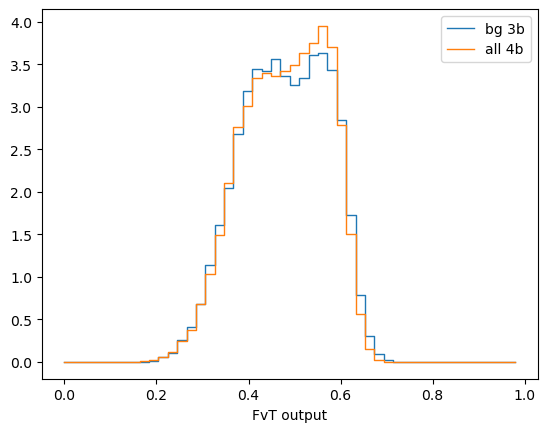

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 3.5 * 2 * dim_quadjet_features))
outer = gridspec.GridSpec(2*dim_quadjet_features, 3, hspace=1.5, wspace=0.3)

is_3b_test = labels_4b_test == 0
is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)
plot_density = True

for i in range(dim_quadjet_features):
    for j in range(3):
        
        repr_min, repr_max = np.min(q_repr_test[:, i, j]), np.max(q_repr_test[:, i, j])
        bins_range = np.linspace(repr_min, repr_max, 50)
        repr_hist_3b, _ = np.histogram(q_repr_test[is_3b_test, i, j], bins=bins_range, density=True)
        repr_hist_4b, _ = np.histogram(q_repr_test[is_bg4b_test, i, j], bins=bins_range, density=True)
        repr_hist_hh4b, _ = np.histogram(q_repr_test[is_hh4b_test, i, j], bins=bins_range, density=True)

        inner = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.2, height_ratios=[1, 1, 1, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.step(bins_range[:-1], repr_hist_3b, label="bg 3b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_4b, label="bg 4b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_hh4b, label="HH 4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
        current_ax.set_title(f"View {j}, Feature {i}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])

        repr_hist_3b, _ = np.histogram(q_repr_test[is_3b_test, i, j], bins=bins_range, density=False)
        repr_hist_4b, _ = np.histogram(q_repr_test[is_bg4b_test, i, j], bins=bins_range, density=False)
        repr_hist_hh4b, _ = np.histogram(q_repr_test[is_hh4b_test, i, j], bins=bins_range, density=False)

        current_ax.step(bins_range[:-1], repr_hist_3b, label="bg 3b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_4b, label="bg 4b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_hh4b, label="HH 4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
        # current_ax.set_title(f"View {j}, Feature {i}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[2])
        # ratio = repr_hist_4b - repr_hist_3b
        # current_ax.axhline(0, color="red", linestyle="--")
        # current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        # fig.add_subplot(current_ax)
        repr_hist_3b, _ = np.histogram(q_repr_test[is_3b_test, i, j], bins=bins_range, density=True)
        repr_hist_4b_all, _ = np.histogram(q_repr_test[labels_4b_test == 1, i, j], bins=bins_range, density=True)
        current_ax.step(bins_range[:-1], repr_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_4b_all, label="all 4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b_all))
        # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()

        fig.add_subplot(current_ax)
        current_ax = plt.Subplot(fig, inner[3])
        # ratio = repr_hist_4b - repr_hist_3b
        # current_ax.axhline(0, color="red", linestyle="--")
        # current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        # fig.add_subplot(current_ax)
        repr_hist_3b, _ = np.histogram(q_repr_test[is_3b_test, i, j], bins=bins_range, density=False)
        repr_hist_4b_all, _ = np.histogram(q_repr_test[labels_4b_test == 1, i, j], bins=bins_range, density=False)
        current_ax.step(bins_range[:-1], repr_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], repr_hist_4b_all, label="all 4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b_all))
        # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
        # remove x labels
        current_ax.legend()
        fig.add_subplot(current_ax)


plt.show()
plt.close()

bins_range = np.linspace(0, 1, 50)
repr_hist_3b, _ = np.histogram(probs_4b_test[is_3b_test], bins=bins_range, density=True)
repr_hist_4b, _ = np.histogram(probs_4b_test[is_bg4b_test], bins=bins_range, density=True)
repr_hist_hh4b, _ = np.histogram(probs_4b_test[is_hh4b_test], bins=bins_range, density=True)
repr_hist_4b_all, _ = np.histogram(probs_4b_test[labels_4b_test == 1], bins=bins_range, density=True)

fig, ax = plt.subplots()
ax.step(bins_range[:-1], repr_hist_3b, label="bg 3b", linewidth=1)
ax.step(bins_range[:-1], repr_hist_4b, label="bg 4b", linewidth=1)
ax.step(bins_range[:-1], repr_hist_hh4b, label="HH 4b", linewidth=1)
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

fig, ax = plt.subplots()
ax.step(bins_range[:-1], repr_hist_3b, label="bg 3b", linewidth=1)
ax.step(bins_range[:-1], repr_hist_4b_all, label="all 4b", linewidth=1)
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()


In [29]:
pl.seed_everything(42)

is_hh4b_test = is_signal_test == 1
is_bg4b_test = (is_signal_test == 0) & (labels_4b_test == 1)


q_train, q_test, y2_train, y2_test, w2_train, w2_test = train_test_split(q_repr_test[is_hh4b_test | is_bg4b_test], 
                                                                         is_hh4b_test[is_hh4b_test | is_bg4b_test], 
                                                                         w_test[is_hh4b_test | is_bg4b_test],
                                                                         test_size=0.2, random_state=42)

device = torch.device("cuda:0")
svb_model = SvBSimple(dim_quadjet_features).to(device)
optimizer = torch.optim.Adam(svb_model.parameters(), lr=1e-3)

train_dataset = TensorDataset(torch.tensor(q_train, dtype=torch.float32), 
                              torch.tensor(y2_train, dtype=torch.long), 
                              torch.tensor(w2_train, dtype=torch.float32))
svb_test_dataset = TensorDataset(torch.tensor(q_test, dtype=torch.float32), 
                            torch.tensor(y2_test, dtype=torch.long), 
                            torch.tensor(w2_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(svb_test_dataset, batch_size=1024, shuffle=False)

svb_model.fit(train_loader, test_loader, optimizer, 25)

Seed set to 42


/tmp/ipykernel_305606/461808701.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(w2_train, dtype=torch.float32))
/tmp/ipykernel_305606/461808701.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(w2_test, dtype=torch.float32))


Epoch 0 Val Loss: 75.31449127197266
Epoch 5 Val Loss: 31.34521484375
Epoch 10 Val Loss: 23.33315086364746
Epoch 15 Val Loss: 23.893774032592773
Epoch 20 Val Loss: 22.48400115966797


TypeError: step() missing 1 required positional argument: 'y'

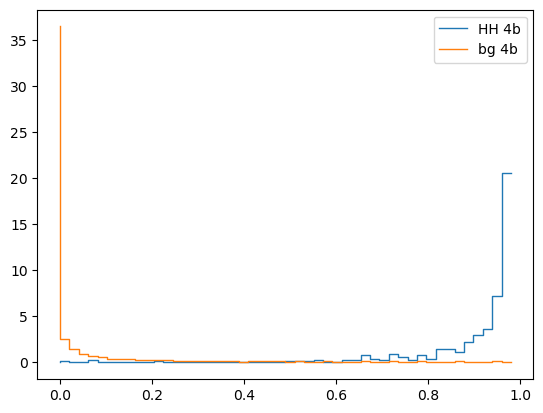

In [30]:
logits = svb_model.logit(torch.tensor(q_test, dtype=torch.float32).to(device)).detach().cpu().numpy()
prob_signal = 1 / (1 + np.exp(-logits))

bins_range = np.linspace(0, 1, 50)
tmp_hh4b, _ = np.histogram(prob_signal[y2_test], bins=bins_range, density=True)
tmp_bg4b, _ = np.histogram(prob_signal[~y2_test], bins=bins_range, density=True)

plt.step(bins_range[:-1], tmp_hh4b, label="HH 4b", linewidth=1)
plt.step(bins_range[:-1], tmp_bg4b, label="bg 4b", linewidth=1)
plt.legend()
# plt.yscale("log")
plt.show()
plt.close()

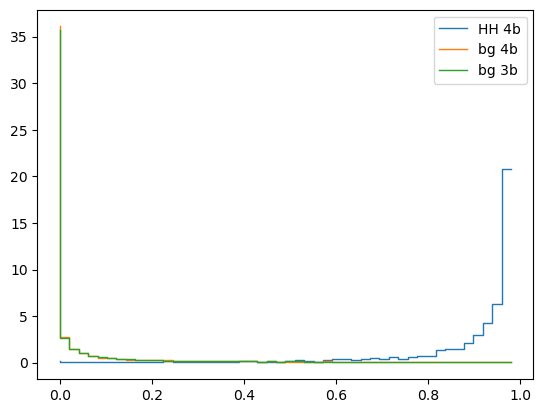

In [33]:
logits_test = svb_model.logit(torch.tensor(q_repr_test, dtype=torch.float32).to(device)).detach().cpu().numpy()
prob_signal_test = 1 / (1 + np.exp(-logits_test))

bins_range = np.linspace(0, 1, 50)
tmp_hh4b, _ = np.histogram(prob_signal_test[is_hh4b_test], bins=bins_range, density=True)
tmp_bg4b, _ = np.histogram(prob_signal_test[is_bg4b_test], bins=bins_range, density=True)
tmp_3b, _ = np.histogram(prob_signal_test[is_3b_test], bins=bins_range, density=True)

plt.step(bins_range[:-1], tmp_hh4b, label="HH 4b", linewidth=1)
plt.step(bins_range[:-1], tmp_bg4b, label="bg 4b", linewidth=1)
plt.step(bins_range[:-1], tmp_3b, label="bg 3b", linewidth=1)
plt.legend()
# plt.yscale("log")
plt.show()
plt.close()